In [5]:
import requests
import re
import pandas as pd
import numpy as np
from bizdays import return_none
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize

### Constructing Bag of Words

In [4]:
cv = CountVectorizer()
texts =["Hello, this is a python course", "Hi, my bike broke this tuesday"]

X = cv.fit_transform(texts)

df = pd.DataFrame(X.toarray(), columns=cv.get_feature_names_out())

df

,bike,broke,course,hello,hi,is,my,python,this,tuesday
0,0,0,1,1,0,1,0,1,1,0
1,1,1,0,0,1,0,1,0,1,1


### Constructing Bag of Words with stopwords and tokenizers

In [7]:
cv = CountVectorizer(stop_words='english', tokenizer=word_tokenize)
texts =["Hello, this is a python course", "Hi, my bike broke this tuesday"]

X = cv.fit_transform(texts)

df = pd.DataFrame(X.toarray(), columns=cv.get_feature_names_out())

df

/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,",",bike,broke,course,hello,hi,python,tuesday
0,1,0,0,1,1,0,1,0
1,1,1,1,0,0,1,0,1


### Computing Jaccard similarity between two different texts

In [11]:
path = "/Users/eduardo/Downloads/all_ECB_speeches.csv"

df = pd.read_csv(path, sep="|", ).dropna()

text = df['contents'].tolist()

X = cv.fit_transform(text)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


#### Cosine similarity by hand

In [13]:
arr1 = X[0].toarray().flatten()
arr2 = X[1].toarray().flatten()

numerator = np.sum(arr1 * arr2)
denominator = np.sqrt(np.sum(arr1 ** 2)) * np.sqrt(np.sum(arr2 ** 2))
print(numerator / denominator)

#### Cosine similarity using `cosine_similarity` package

In [14]:
from sklearn.metrics.pairwise import cosine_similarity

print(cosine_similarity(X[0].toarray(), X[1].toarray()))

0.8221334445162073
[[0.82213344]]


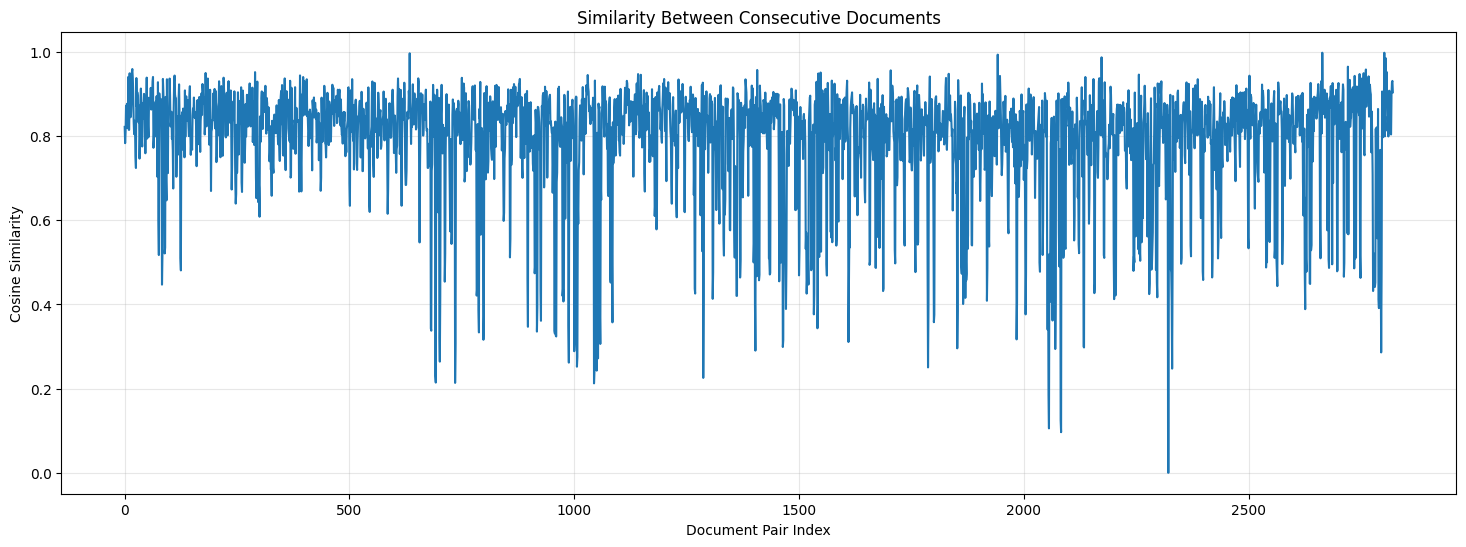

In [34]:
similarity = []

for i in range(X.shape[0]-1):
    arr1 = X[i].toarray()
    arr2 = X[i+1].toarray()
    similarity.append(cosine_similarity(arr1, arr2)[0][0])

plt.figure(figsize=(18, 6))
plt.plot(similarity)
plt.xlabel('Document Pair Index')
plt.ylabel('Cosine Similarity')
plt.title('Similarity Between Consecutive Documents')
plt.grid(True, alpha=0.3)
plt.show()

#### Computing Jaccard Similarity

In [42]:
def jaccard_score(arr1, arr2):
    numerator = np.sum((arr1.toarray() >0) & (arr2.toarray() > 0))
    denominator = np.sum((arr1.toarray() > 0) | (arr2.toarray() > 0))

    jaccard = numerator / denominator

    return jaccard

results = [jaccard_score(X[i], X[i+1]).item() for i in range(X.shape[0] -1)]

results = results +[0]

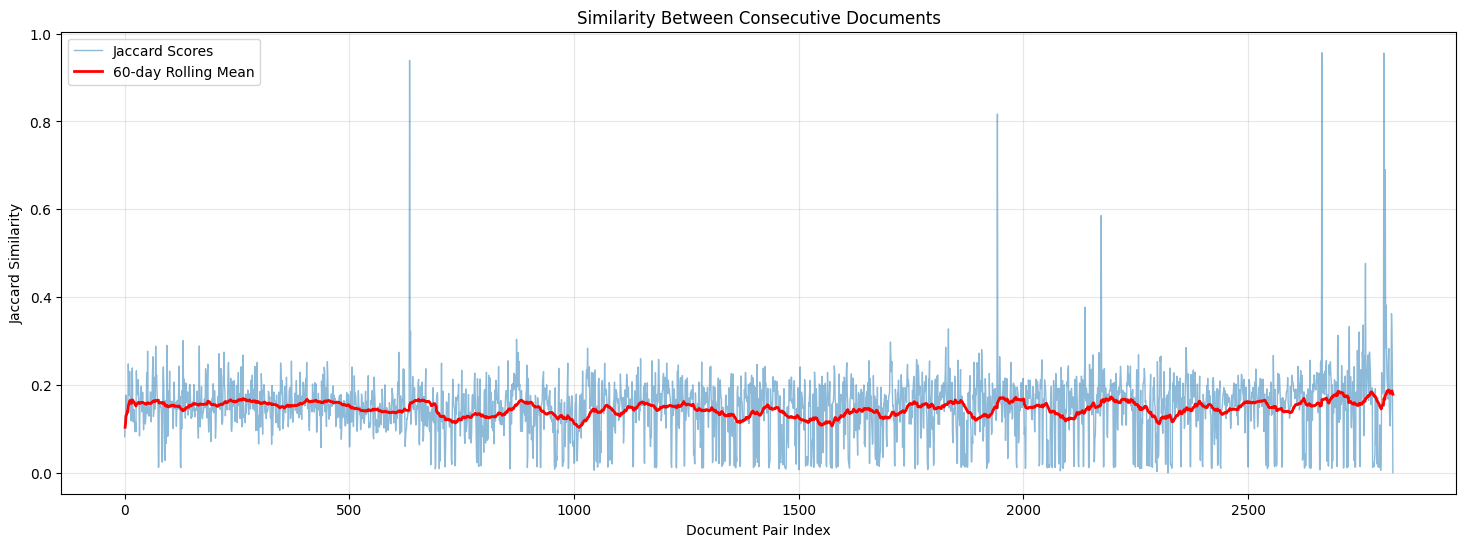

In [55]:
rolling_mean = pd.Series(results).rolling(window=60, min_periods=2).mean()


plt.figure(figsize=(18, 6))
plt.plot(results, alpha=0.5, label='Jaccard Scores', linewidth=1)
plt.plot(rolling_mean, label='60-day Rolling Mean', linewidth=2, color='red')
plt.xlabel('Document Pair Index')
plt.ylabel('Jaccard Similarity')
plt.title('Similarity Between Consecutive Documents')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Jaccard similarity measures overlap based on binary presence/absence of features, ignoring feature magnitudes, weights or frequency. Cosine similarity measures angular alignment between vectors, considering both frequency and magnitude/weight of features.

Example: Two documents with words ["apple", "banana"] vs ["apple", "apple", "apple"] have Jaccard = 0.5 (share 1 of 2 unique words) but Cosine ≈ 0.71 (both point in similar direction despite frequency differences).

---

### My first sentiment

In [66]:
text = ["I love you", "The war is coming", "That's bad.", "He hates you"]

dict_p = ["good", "love", "laugh", "fun"]
dict_n = ["bad", "crisis", "war", "hate"]

from nltk import word_tokenize

def compute_sentiment(text):
    tokens = word_tokenize(text)
    pos_score = np.sum([t in dict_p for t in tokens])
    neg_score = np.sum([t in dict_n for t in tokens])

    if (pos_score + neg_score) > 0:
        sentiment = (pos_score - neg_score)/(pos_score + neg_score)
    else:
        sentiment = 0

    return sentiment

for text in text:
    print(compute_sentiment(text))

1.0
-1.0
-1.0
0


### Sentiment Analysis with Loughran & McDonald Dictionary for finance

#### Load LM dict

In [86]:
texts = """The global factory activity slowed down in June on a toxic mix of the Russia-Ukraine conflict, inflation pressure and the pandemic, data from the China Federation of Logistics and Purchasing (CFLP) showed on Wednesday.

The June global manufacturing Purchasing Managers' Index (PMI) fell to the lowest in the year to 52.3, dropping 1.2 percentage points from May, CFLP data showed.

In terms of regions, June manufacturing PMI increased slightly in Asia from the previous month. However, the index declined around 2 percentage points across Europe, America and Africa, indicating a weakening of economic recovery.

Asian June manufacturing PMI came in at 51.4, an increase for 2 consecutive months, indicating relatively stable growth in the region.

Notably, China's June Caixin manufacturing PMI rose to 51.7, the highest reading in 13 months as production quickly recovers.

CFLP cautioned that many Asian countries are mired in uncertainties with the high inflation coupled with low growth. Inflation rates are rising rapidly in countries such as South Korea, the Philippines and Thailand, driven by rising oil and food prices.

The European manufacturing PMI declined for five consecutive months to 52.4 in June. The European economy is under considerable pressure because of energy shock, the pandemic and labor shortages, the CFLP said in a report.

While economic growth is slowing, inflation soared in Europe. Eurozone inflation hit a record high in June at 8.6 percent, official data showed.

The American manufacturing PMI dropped to 53.2 in June, among which, the U.S. manufacturing PMI edged down 3.1 percentage points from the previous month to 53. The U.S. new orders index fell nearly 6 percentage points, indicating a significant walk back in demand from May.

The U.S. stagflation pressure is gradually adding up as the country raises interest rates to tame inflation, the CFLP said.

The U.S. federal reserve started to raise interest rates off zero in March to combat price surges. It hiked rates by 0.75 percentage points in June, the biggest increase in 28 years. The hawkish stance fuels recession fears. In the latest report, Bloomberg economists see a 38 percent chance of a U.S. recession in the next 12 months.

The World Bank slashed its 2022 global growth forecast to 2.9 percent as the Russia-Ukraine conflict and COVID-19 pandemic weigh on growth. The bank also warned of the elevated risk of global stagflation.""".splitlines()

texts = [text for text in texts if text]

texts

['The global factory activity slowed down in June on a toxic mix of the Russia-Ukraine conflict, inflation pressure and the pandemic, data from the China Federation of Logistics and Purchasing (CFLP) showed on Wednesday.',
 "The June global manufacturing Purchasing Managers' Index (PMI) fell to the lowest in the year to 52.3, dropping 1.2 percentage points from May, CFLP data showed.",
 'In terms of regions, June manufacturing PMI increased slightly in Asia from the previous month. However, the index declined around 2 percentage points across Europe, America and Africa, indicating a weakening of economic recovery.',
 'Asian June manufacturing PMI came in at 51.4, an increase for 2 consecutive months, indicating relatively stable growth in the region.',
 "Notably, China's June Caixin manufacturing PMI rose to 51.7, the highest reading in 13 months as production quickly recovers.",
 'CFLP cautioned that many Asian countries are mired in uncertainties with the high inflation coupled with 

In [97]:
lm = pd.read_csv("/Users/eduardo/Downloads/Loughran-McDonald_MasterDictionary_1993-2024.csv")

# Convert words to lowercase for matching
lm['Word_lower'] = lm['Word'].str.lower()

# Get positive and negative words
lm_pos = lm[lm['Positive'] > 0]['Word_lower'].tolist()
lm_neg = lm[lm['Negative'] > 0]['Word_lower'].tolist()

In [95]:
def compute_sentiment(text):

    tokens = word_tokenize(text)

    pos_score = sum([t in lm_pos for t in tokens])
    neg_score = sum([t in lm_neg for t in tokens])

    if (pos_score + neg_score) > 0:
        sentiment = (pos_score - neg_score)/(pos_score + neg_score)
    else:
        sentiment = 0

    return sentiment

for text in texts:
    print(compute_sentiment(text))

-1.0
0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
0
-1.0
-1.0


#### Issues with lexicon approach

The approach is not able to capture the negative structure of the sentence

In [96]:
compute_sentiment("I did not win this time.")

1.0

### `vaderSentiment` enables us to a better infer sentiments from texts, specially from social media

In [99]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

sentences = ['VADER is smart, handsome, and funny']

analyzer = SentimentIntensityAnalyzer()

for sentence in sentences:
    sentiment = analyzer.polarity_scores(sentence)
    print(sentence, sentiment)

VADER is smart, handsome, and funny {'neg': 0.0, 'neu': 0.254, 'pos': 0.746, 'compound': 0.8316}


In [105]:
df = pd.read_csv("/Users/eduardo/Downloads/tweets_2.txt", sep="\t", header=None)
df.columns = ['index', 'score', 'text']

In [108]:
def convert_score_to_label(score):
    return (score > 0.05) * 1 + (score < -0.05) * -1

df['labels'] = df['score'].apply(convert_score_to_label)

df

,index,score,text,labels
0,1,2.726316,Somehow I was blessed with some really amazing...,1
1,2,1.443299,Yay. Another good phone interview.,1
2,3,2.873684,We were 17 deep last night &amp;amp; the love ...,1
3,4,2.857143,"LMAO, AMAZING!",1
4,5,-2.154639,Two words that should die this year: Sexting a...,-1
...,...,...,...,...
4195,4196,1.650000,Guild Wars 2: Concept Art and Video http://url...,1
4196,4197,-0.450000,@anonymous but i do think in this case that th...,-1
4197,4198,0.900000,TRUTH! RT @anonymous Your customers will share...,1
4198,4199,1.100000,"Imagine you can touch it, feel it, taste it &a...",1


In [109]:
df['labels'].value_counts()

labels
 1    2824
-1    1268
 0     108
Name: count, dtype: int64

In [110]:
vader = SentimentIntensityAnalyzer()
df['score_vader'] = (df['text'].apply(lambda x: vader.polarity_scores(x)['compound']))
df['labels_vader'] = df['score_vader'].apply(convert_score_to_label)

(df['labels'] == df['labels_vader']).mean()

0.9057142857142857